# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creamos función de costo

In [20]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:

model = Sequential()
model.add(Flatten(input_shape=(2,100,100)))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(128,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))

model.add(Dense(7, activation= custom_activation))

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation= custom_activation)
])



In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 100)               2000100   
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 25)                1275      
                                                      

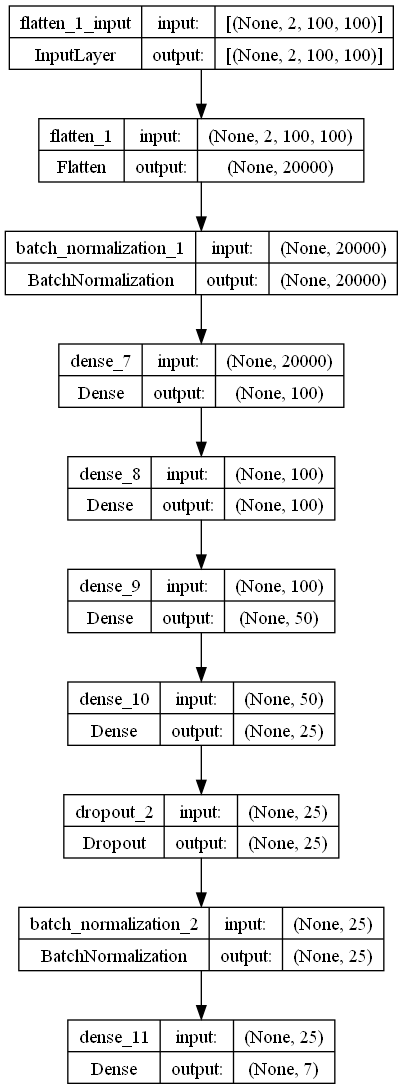

In [25]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [26]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [27]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [28]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [29]:
model.compile(optimizer=optimizer,
              loss= custom_loss,
              metrics=metrics)

In [30]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [ ]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_mean_metric', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 6s 62ms/step - loss: 46.1465 - a_1: 3.0948 - a_2: 3.1739 - b_1: 2.9683 - b_2: 3.0135 - d_1: 1.4274 - d_2: 1.3548 - n: 2.8585 - mean_metric: 0.5930 - val_loss: 46.3209 - val_a_1: 3.1958 - val_a_2: 3.1011 - val_b_1: 3.0313 - val_b_2: 3.0583 - val_d_1: 1.2998 - val_d_2: 1.4975 - val_n: 3.8560 - val_mean_metric: 0.6303 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 4s 56ms/step - loss: 40.2100 - a_1: 3.1058 - a_2: 3.0569 - b_1: 2.9416 - b_2: 3.1484 - d_1: 1.2022 - d_2: 1.1999 - n: 2.8874 - mean_metric: 0.5814 - val_loss: 40.1250 - val_a_1: 2.9585 - val_a_2: 2.8757 - val_b_1: 2.8537 - val_b_2: 2.8465 - val_d_1: 1.1274 - val_d_2: 1.3426 - val_n: 2.7488 - val_mean_metric: 0.5546 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 4s 57ms/step - loss: 38.7752 - a_1: 3.1458 - a_2: 2.9529 - b_1: 2.9171 - b_2: 2.9511 - d_1: 1.1657 - d_2: 1.1550 - n: 2.8238 - mean_metric: 0.5671 - val_loss: 34.1607 - val_a_1: 

70/70 [==============================] - 4s 57ms/step - loss: 22.3455 - a_1: 2.8415 - a_2: 2.7635 - b_1: 2.7101 - b_2: 2.7219 - d_1: 0.9716 - d_2: 0.9596 - n: 3.2440 - mean_metric: 0.5374 - val_loss: 19.8213 - val_a_1: 2.7392 - val_a_2: 2.6916 - val_b_1: 2.6543 - val_b_2: 2.5395 - val_d_1: 0.8572 - val_d_2: 0.8353 - val_n: 3.1660 - val_mean_metric: 0.5123 - lr: 0.0010
Epoch 23/1000
70/70 [==============================] - 4s 57ms/step - loss: 21.9475 - a_1: 2.8214 - a_2: 2.8067 - b_1: 2.7467 - b_2: 2.7550 - d_1: 0.9560 - d_2: 0.9334 - n: 3.2433 - mean_metric: 0.5390 - val_loss: 19.7036 - val_a_1: 2.6958 - val_a_2: 2.7211 - val_b_1: 2.7060 - val_b_2: 2.5707 - val_d_1: 0.8848 - val_d_2: 0.8166 - val_n: 3.2492 - val_mean_metric: 0.5176 - lr: 0.0010
Epoch 24/1000
70/70 [==============================] - 4s 56ms/step - loss: 22.0470 - a_1: 2.8094 - a_2: 2.7727 - b_1: 2.7358 - b_2: 2.7162 - d_1: 0.9510 - d_2: 0.9487 - n: 3.2445 - mean_metric: 0.5363 - val_loss: 20.3558 - val_a_1: 2.7345 - va

70/70 [==============================] - 4s 57ms/step - loss: 20.6980 - a_1: 2.7863 - a_2: 2.8207 - b_1: 2.7329 - b_2: 2.6488 - d_1: 0.9052 - d_2: 0.9073 - n: 3.3004 - mean_metric: 0.5337 - val_loss: 19.2470 - val_a_1: 2.6921 - val_a_2: 2.6895 - val_b_1: 2.5954 - val_b_2: 2.4677 - val_d_1: 0.8615 - val_d_2: 0.8106 - val_n: 3.1018 - val_mean_metric: 0.5036 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 4s 57ms/step - loss: 20.6139 - a_1: 2.7668 - a_2: 2.7973 - b_1: 2.7015 - b_2: 2.6206 - d_1: 0.8974 - d_2: 0.9033 - n: 3.2770 - mean_metric: 0.5291 - val_loss: 19.5799 - val_a_1: 2.7388 - val_a_2: 2.6926 - val_b_1: 2.6070 - val_b_2: 2.4592 - val_d_1: 0.8661 - val_d_2: 0.8451 - val_n: 3.0878 - val_mean_metric: 0.5061 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 4s 57ms/step - loss: 20.6990 - a_1: 2.7620 - a_2: 2.8053 - b_1: 2.6924 - b_2: 2.6575 - d_1: 0.9151 - d_2: 0.9019 - n: 3.2402 - mean_metric: 0.5296 - val_loss: 18.5358 - val_a_1: 2.7250 - va

70/70 [==============================] - 4s 57ms/step - loss: 19.6281 - a_1: 2.7519 - a_2: 2.8232 - b_1: 2.6959 - b_2: 2.6447 - d_1: 0.8831 - d_2: 0.8736 - n: 3.2603 - mean_metric: 0.5281 - val_loss: 18.1104 - val_a_1: 2.7301 - val_a_2: 2.7538 - val_b_1: 2.5529 - val_b_2: 2.4154 - val_d_1: 0.8404 - val_d_2: 0.7863 - val_n: 3.2994 - val_mean_metric: 0.5089 - lr: 0.0010
Epoch 65/1000
70/70 [==============================] - 4s 57ms/step - loss: 19.4350 - a_1: 2.7662 - a_2: 2.8351 - b_1: 2.6998 - b_2: 2.5726 - d_1: 0.8773 - d_2: 0.8593 - n: 3.2931 - mean_metric: 0.5272 - val_loss: 17.7991 - val_a_1: 2.7399 - val_a_2: 2.6792 - val_b_1: 2.5672 - val_b_2: 2.4014 - val_d_1: 0.8181 - val_d_2: 0.7662 - val_n: 3.0716 - val_mean_metric: 0.4979 - lr: 0.0010
Epoch 66/1000
70/70 [==============================] - 4s 58ms/step - loss: 19.2732 - a_1: 2.7687 - a_2: 2.8008 - b_1: 2.6877 - b_2: 2.5734 - d_1: 0.8742 - d_2: 0.8511 - n: 3.3061 - mean_metric: 0.5258 - val_loss: 17.6970 - val_a_1: 2.7297 - va

70/70 [==============================] - 4s 57ms/step - loss: 18.3514 - a_1: 2.7523 - a_2: 2.8310 - b_1: 2.6491 - b_2: 2.5033 - d_1: 0.8520 - d_2: 0.8329 - n: 3.2253 - mean_metric: 0.5185 - val_loss: 16.6302 - val_a_1: 2.7233 - val_a_2: 2.7257 - val_b_1: 2.5262 - val_b_2: 2.2727 - val_d_1: 0.7822 - val_d_2: 0.7478 - val_n: 2.9477 - val_mean_metric: 0.4873 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 4s 57ms/step - loss: 18.3958 - a_1: 2.7605 - a_2: 2.8277 - b_1: 2.6574 - b_2: 2.5012 - d_1: 0.8427 - d_2: 0.8533 - n: 3.2249 - mean_metric: 0.5193 - val_loss: 16.4708 - val_a_1: 2.7137 - val_a_2: 2.7174 - val_b_1: 2.4984 - val_b_2: 2.3249 - val_d_1: 0.8014 - val_d_2: 0.7396 - val_n: 3.0154 - val_mean_metric: 0.4901 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 4s 56ms/step - loss: 18.2965 - a_1: 2.7811 - a_2: 2.8376 - b_1: 2.6408 - b_2: 2.4666 - d_1: 0.8592 - d_2: 0.8304 - n: 3.2107 - mean_metric: 0.5179 - val_loss: 16.7478 - val_a_1: 2.7135 - va

70/70 [==============================] - 4s 57ms/step - loss: 17.6951 - a_1: 2.8021 - a_2: 2.8954 - b_1: 2.6579 - b_2: 2.5506 - d_1: 0.8350 - d_2: 0.8301 - n: 3.1665 - mean_metric: 0.5217 - val_loss: 16.0138 - val_a_1: 2.7296 - val_a_2: 2.7629 - val_b_1: 2.4520 - val_b_2: 2.2593 - val_d_1: 0.7684 - val_d_2: 0.7334 - val_n: 2.9337 - val_mean_metric: 0.4845 - lr: 0.0010
Epoch 107/1000
70/70 [==============================] - 4s 57ms/step - loss: 17.7113 - a_1: 2.7864 - a_2: 2.8853 - b_1: 2.6277 - b_2: 2.4743 - d_1: 0.8427 - d_2: 0.8290 - n: 3.1329 - mean_metric: 0.5164 - val_loss: 16.1889 - val_a_1: 2.7173 - val_a_2: 2.7669 - val_b_1: 2.4570 - val_b_2: 2.3835 - val_d_1: 0.7952 - val_d_2: 0.7489 - val_n: 3.1924 - val_mean_metric: 0.4985 - lr: 0.0010
Epoch 108/1000
70/70 [==============================] - 4s 57ms/step - loss: 17.2302 - a_1: 2.7962 - a_2: 2.8703 - b_1: 2.6000 - b_2: 2.4779 - d_1: 0.8246 - d_2: 0.8012 - n: 3.1424 - mean_metric: 0.5142 - val_loss: 16.4017 - val_a_1: 2.7520 - 

70/70 [==============================] - 4s 57ms/step - loss: 16.9837 - a_1: 2.8393 - a_2: 2.9106 - b_1: 2.5880 - b_2: 2.4453 - d_1: 0.8088 - d_2: 0.7951 - n: 3.1335 - mean_metric: 0.5144 - val_loss: 16.0077 - val_a_1: 2.7934 - val_a_2: 2.7736 - val_b_1: 2.3884 - val_b_2: 2.3865 - val_d_1: 0.7812 - val_d_2: 0.7452 - val_n: 3.0670 - val_mean_metric: 0.4943 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 4s 59ms/step - loss: 16.8472 - a_1: 2.8469 - a_2: 2.9197 - b_1: 2.5571 - b_2: 2.4631 - d_1: 0.7955 - d_2: 0.7957 - n: 3.1333 - mean_metric: 0.5142 - val_loss: 16.1537 - val_a_1: 2.7766 - val_a_2: 2.7905 - val_b_1: 2.4281 - val_b_2: 2.2567 - val_d_1: 0.7744 - val_d_2: 0.7460 - val_n: 2.7111 - val_mean_metric: 0.4794 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 4s 57ms/step - loss: 17.1094 - a_1: 2.8509 - a_2: 2.8963 - b_1: 2.6218 - b_2: 2.4296 - d_1: 0.8122 - d_2: 0.8071 - n: 3.1267 - mean_metric: 0.5153 - val_loss: 16.1178 - val_a_1: 2.7944 - 

70/70 [==============================] - 4s 56ms/step - loss: 16.5417 - a_1: 2.8665 - a_2: 2.9405 - b_1: 2.5476 - b_2: 2.3856 - d_1: 0.7913 - d_2: 0.7731 - n: 3.1386 - mean_metric: 0.5119 - val_loss: 16.1039 - val_a_1: 2.7978 - val_a_2: 2.7824 - val_b_1: 2.3618 - val_b_2: 2.1605 - val_d_1: 0.7862 - val_d_2: 0.7463 - val_n: 2.8341 - val_mean_metric: 0.4788 - lr: 0.0010
Epoch 149/1000
70/70 [==============================] - 4s 56ms/step - loss: 16.5963 - a_1: 2.8529 - a_2: 2.9443 - b_1: 2.5747 - b_2: 2.3805 - d_1: 0.7894 - d_2: 0.7787 - n: 3.1185 - mean_metric: 0.5118 - val_loss: 16.1333 - val_a_1: 2.8038 - val_a_2: 2.7752 - val_b_1: 2.3411 - val_b_2: 2.2326 - val_d_1: 0.8126 - val_d_2: 0.7557 - val_n: 3.0454 - val_mean_metric: 0.4887 - lr: 0.0010
Epoch 150/1000
70/70 [==============================] - 4s 57ms/step - loss: 16.3743 - a_1: 2.8564 - a_2: 2.9344 - b_1: 2.5661 - b_2: 2.3611 - d_1: 0.7726 - d_2: 0.7745 - n: 3.1542 - mean_metric: 0.5111 - val_loss: 15.6986 - val_a_1: 2.8247 - 

70/70 [==============================] - 4s 56ms/step - loss: 16.0749 - a_1: 2.8811 - a_2: 2.9612 - b_1: 2.5315 - b_2: 2.3921 - d_1: 0.7617 - d_2: 0.7623 - n: 3.1607 - mean_metric: 0.5122 - val_loss: 15.9639 - val_a_1: 2.8393 - val_a_2: 2.8076 - val_b_1: 2.3985 - val_b_2: 2.4281 - val_d_1: 0.7937 - val_d_2: 0.7250 - val_n: 2.9059 - val_mean_metric: 0.4931 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 4s 56ms/step - loss: 15.9434 - a_1: 2.8937 - a_2: 2.9594 - b_1: 2.5177 - b_2: 2.3797 - d_1: 0.7624 - d_2: 0.7448 - n: 3.1415 - mean_metric: 0.5103 - val_loss: 16.6039 - val_a_1: 2.7768 - val_a_2: 2.7904 - val_b_1: 2.3226 - val_b_2: 2.2454 - val_d_1: 0.8345 - val_d_2: 0.7457 - val_n: 2.8235 - val_mean_metric: 0.4812 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 4s 56ms/step - loss: 16.0972 - a_1: 2.8944 - a_2: 2.9623 - b_1: 2.5333 - b_2: 2.3838 - d_1: 0.7717 - d_2: 0.7554 - n: 3.1350 - mean_metric: 0.5116 - val_loss: 16.2642 - val_a_1: 2.8394 - 

70/70 [==============================] - 4s 57ms/step - loss: 15.9087 - a_1: 2.9106 - a_2: 2.9667 - b_1: 2.4510 - b_2: 2.3337 - d_1: 0.7570 - d_2: 0.7402 - n: 3.1480 - mean_metric: 0.5073 - val_loss: 15.7850 - val_a_1: 2.8531 - val_a_2: 2.8309 - val_b_1: 2.3361 - val_b_2: 2.2781 - val_d_1: 0.7851 - val_d_2: 0.7320 - val_n: 2.8622 - val_mean_metric: 0.4858 - lr: 0.0010
Epoch 191/1000
70/70 [==============================] - 4s 57ms/step - loss: 15.8577 - a_1: 2.9014 - a_2: 3.0126 - b_1: 2.5212 - b_2: 2.3550 - d_1: 0.7492 - d_2: 0.7465 - n: 3.1323 - mean_metric: 0.5110 - val_loss: 16.2341 - val_a_1: 2.8421 - val_a_2: 2.7809 - val_b_1: 2.2136 - val_b_2: 2.1815 - val_d_1: 0.8122 - val_d_2: 0.7547 - val_n: 2.7671 - val_mean_metric: 0.4750 - lr: 0.0010
Epoch 192/1000
70/70 [==============================] - 4s 56ms/step - loss: 15.9156 - a_1: 2.8858 - a_2: 2.9452 - b_1: 2.4732 - b_2: 2.3567 - d_1: 0.7485 - d_2: 0.7580 - n: 3.1515 - mean_metric: 0.5078 - val_loss: 16.1847 - val_a_1: 2.8684 - 

70/70 [==============================] - 4s 57ms/step - loss: 15.5831 - a_1: 2.9102 - a_2: 3.0272 - b_1: 2.3984 - b_2: 2.3728 - d_1: 0.7413 - d_2: 0.7279 - n: 3.1421 - mean_metric: 0.5078 - val_loss: 16.1782 - val_a_1: 2.9042 - val_a_2: 2.8865 - val_b_1: 2.2385 - val_b_2: 2.3310 - val_d_1: 0.8269 - val_d_2: 0.7335 - val_n: 2.9502 - val_mean_metric: 0.4922 - lr: 0.0010
Epoch 212/1000
70/70 [==============================] - 4s 57ms/step - loss: 15.5510 - a_1: 2.9230 - a_2: 3.0008 - b_1: 2.4707 - b_2: 2.3449 - d_1: 0.7288 - d_2: 0.7359 - n: 3.1348 - mean_metric: 0.5085 - val_loss: 16.2614 - val_a_1: 2.8681 - val_a_2: 2.8346 - val_b_1: 2.2722 - val_b_2: 2.3527 - val_d_1: 0.8088 - val_d_2: 0.7505 - val_n: 2.7642 - val_mean_metric: 0.4849 - lr: 0.0010
Epoch 213/1000
70/70 [==============================] - 4s 57ms/step - loss: 15.5449 - a_1: 2.9261 - a_2: 2.9714 - b_1: 2.4337 - b_2: 2.3908 - d_1: 0.7395 - d_2: 0.7252 - n: 3.1007 - mean_metric: 0.5068 - val_loss: 16.0385 - val_a_1: 2.8820 - 

70/70 [==============================] - 4s 56ms/step - loss: 15.4475 - a_1: 2.9392 - a_2: 3.0153 - b_1: 2.1776 - b_2: 2.3838 - d_1: 0.7371 - d_2: 0.7178 - n: 3.1397 - mean_metric: 0.5009 - val_loss: 16.1791 - val_a_1: 2.8998 - val_a_2: 2.8880 - val_b_1: 1.8146 - val_b_2: 2.2006 - val_d_1: 0.8103 - val_d_2: 0.7602 - val_n: 2.8138 - val_mean_metric: 0.4695 - lr: 0.0010
Epoch 233/1000
70/70 [==============================] - 4s 56ms/step - loss: 15.4468 - a_1: 2.9504 - a_2: 3.0290 - b_1: 2.1636 - b_2: 2.4051 - d_1: 0.7205 - d_2: 0.7293 - n: 3.1114 - mean_metric: 0.5008 - val_loss: 16.0048 - val_a_1: 2.9080 - val_a_2: 2.8622 - val_b_1: 1.7854 - val_b_2: 2.3196 - val_d_1: 0.7948 - val_d_2: 0.7500 - val_n: 2.8872 - val_mean_metric: 0.4735 - lr: 0.0010
Epoch 234/1000
70/70 [==============================] - 4s 56ms/step - loss: 15.6027 - a_1: 2.9330 - a_2: 3.0153 - b_1: 2.1848 - b_2: 2.3756 - d_1: 0.7413 - d_2: 0.7236 - n: 3.1119 - mean_metric: 0.5000 - val_loss: 16.4233 - val_a_1: 2.9092 - 

70/70 [==============================] - 4s 56ms/step - loss: 15.3118 - a_1: 2.9677 - a_2: 3.0635 - b_1: 2.2139 - b_2: 2.3468 - d_1: 0.7150 - d_2: 0.7181 - n: 3.0323 - mean_metric: 0.4991 - val_loss: 16.3916 - val_a_1: 2.9220 - val_a_2: 2.8611 - val_b_1: 1.9294 - val_b_2: 2.3505 - val_d_1: 0.8221 - val_d_2: 0.7551 - val_n: 2.7593 - val_mean_metric: 0.4766 - lr: 0.0010
Epoch 254/1000
70/70 [==============================] - 4s 57ms/step - loss: 14.9275 - a_1: 2.9837 - a_2: 3.0691 - b_1: 2.1982 - b_2: 2.3642 - d_1: 0.6924 - d_2: 0.7072 - n: 3.0880 - mean_metric: 0.5006 - val_loss: 16.7753 - val_a_1: 2.9101 - val_a_2: 2.8769 - val_b_1: 2.0019 - val_b_2: 2.3179 - val_d_1: 0.8510 - val_d_2: 0.7723 - val_n: 2.9233 - val_mean_metric: 0.4850 - lr: 0.0010
Epoch 255/1000
70/70 [==============================] - 4s 57ms/step - loss: 15.3312 - a_1: 2.9583 - a_2: 3.0210 - b_1: 2.1638 - b_2: 2.3608 - d_1: 0.7176 - d_2: 0.7122 - n: 3.0836 - mean_metric: 0.4978 - val_loss: 15.9487 - val_a_1: 2.9064 - 

70/70 [==============================] - 4s 57ms/step - loss: 14.8416 - a_1: 2.9755 - a_2: 3.0943 - b_1: 2.1633 - b_2: 2.3431 - d_1: 0.6967 - d_2: 0.6917 - n: 3.0087 - mean_metric: 0.4963 - val_loss: 16.9826 - val_a_1: 2.9416 - val_a_2: 2.9846 - val_b_1: 1.9426 - val_b_2: 2.4995 - val_d_1: 0.8366 - val_d_2: 0.7983 - val_n: 2.7192 - val_mean_metric: 0.4873 - lr: 0.0010
Epoch 275/1000
70/70 [==============================] - 4s 57ms/step - loss: 14.9152 - a_1: 2.9569 - a_2: 3.1012 - b_1: 2.1824 - b_2: 2.3389 - d_1: 0.7049 - d_2: 0.6946 - n: 2.9654 - mean_metric: 0.4954 - val_loss: 16.3204 - val_a_1: 2.9310 - val_a_2: 2.9268 - val_b_1: 1.9229 - val_b_2: 2.2515 - val_d_1: 0.8178 - val_d_2: 0.7462 - val_n: 2.5757 - val_mean_metric: 0.4691 - lr: 0.0010
Epoch 276/1000
70/70 [==============================] - 4s 57ms/step - loss: 14.9809 - a_1: 2.9503 - a_2: 3.1041 - b_1: 2.1796 - b_2: 2.3159 - d_1: 0.7092 - d_2: 0.6907 - n: 2.9756 - mean_metric: 0.4947 - val_loss: 16.4986 - val_a_1: 2.9483 - 

70/70 [==============================] - 4s 56ms/step - loss: 14.6227 - a_1: 2.9800 - a_2: 3.1381 - b_1: 2.1573 - b_2: 2.2986 - d_1: 0.6747 - d_2: 0.6840 - n: 2.7907 - mean_metric: 0.4881 - val_loss: 16.4841 - val_a_1: 2.9226 - val_a_2: 2.9830 - val_b_1: 1.9893 - val_b_2: 2.2335 - val_d_1: 0.8283 - val_d_2: 0.7687 - val_n: 2.4462 - val_mean_metric: 0.4690 - lr: 0.0010
Epoch 296/1000
70/70 [==============================] - 4s 56ms/step - loss: 14.7274 - a_1: 2.9826 - a_2: 3.1508 - b_1: 2.1885 - b_2: 2.3189 - d_1: 0.6982 - d_2: 0.6812 - n: 2.7917 - mean_metric: 0.4910 - val_loss: 16.6318 - val_a_1: 2.9217 - val_a_2: 3.0193 - val_b_1: 1.8163 - val_b_2: 2.2202 - val_d_1: 0.8328 - val_d_2: 0.7688 - val_n: 2.5337 - val_mean_metric: 0.4672 - lr: 0.0010
Epoch 297/1000
70/70 [==============================] - 4s 56ms/step - loss: 14.7686 - a_1: 2.9847 - a_2: 3.1452 - b_1: 2.1804 - b_2: 2.2623 - d_1: 0.6909 - d_2: 0.6811 - n: 2.8089 - mean_metric: 0.4890 - val_loss: 16.4170 - val_a_1: 2.9463 - 

70/70 [==============================] - 4s 57ms/step - loss: 14.8757 - a_1: 2.9901 - a_2: 3.1857 - b_1: 2.1842 - b_2: 2.2827 - d_1: 0.6835 - d_2: 0.7011 - n: 2.5858 - mean_metric: 0.4842 - val_loss: 16.7019 - val_a_1: 2.9209 - val_a_2: 3.0691 - val_b_1: 1.7893 - val_b_2: 2.1763 - val_d_1: 0.8413 - val_d_2: 0.7503 - val_n: 2.2262 - val_mean_metric: 0.4559 - lr: 0.0010
Epoch 317/1000
70/70 [==============================] - 4s 57ms/step - loss: 14.5561 - a_1: 2.9915 - a_2: 3.1827 - b_1: 2.2001 - b_2: 2.2389 - d_1: 0.6674 - d_2: 0.6791 - n: 2.5558 - mean_metric: 0.4812 - val_loss: 16.5926 - val_a_1: 2.9408 - val_a_2: 3.0379 - val_b_1: 1.8326 - val_b_2: 2.3341 - val_d_1: 0.8202 - val_d_2: 0.7872 - val_n: 2.0996 - val_mean_metric: 0.4585 - lr: 0.0010
Epoch 318/1000
70/70 [==============================] - 4s 58ms/step - loss: 14.5095 - a_1: 3.0144 - a_2: 3.1806 - b_1: 2.1437 - b_2: 2.2925 - d_1: 0.6823 - d_2: 0.6717 - n: 2.5779 - mean_metric: 0.4827 - val_loss: 16.6366 - val_a_1: 2.9644 - 

70/70 [==============================] - 4s 60ms/step - loss: 14.3489 - a_1: 3.0007 - a_2: 3.2090 - b_1: 2.1862 - b_2: 2.2518 - d_1: 0.6704 - d_2: 0.6633 - n: 2.4440 - mean_metric: 0.4781 - val_loss: 16.8369 - val_a_1: 2.9535 - val_a_2: 3.1147 - val_b_1: 2.0508 - val_b_2: 2.2501 - val_d_1: 0.8495 - val_d_2: 0.7753 - val_n: 2.0057 - val_mean_metric: 0.4633 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 4s 60ms/step - loss: 14.1485 - a_1: 3.0119 - a_2: 3.2100 - b_1: 2.2164 - b_2: 2.2805 - d_1: 0.6619 - d_2: 0.6524 - n: 2.4511 - mean_metric: 0.4802 - val_loss: 16.7357 - val_a_1: 2.9639 - val_a_2: 3.1183 - val_b_1: 1.9290 - val_b_2: 2.4314 - val_d_1: 0.8593 - val_d_2: 0.7839 - val_n: 2.0604 - val_mean_metric: 0.4682 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 4s 59ms/step - loss: 14.4455 - a_1: 2.9864 - a_2: 3.2514 - b_1: 2.1772 - b_2: 2.3214 - d_1: 0.6831 - d_2: 0.6611 - n: 2.4543 - mean_metric: 0.4818 - val_loss: 16.7297 - val_a_1: 2.9407 - 

70/70 [==============================] - 4s 57ms/step - loss: 14.2138 - a_1: 3.0040 - a_2: 3.2367 - b_1: 2.2244 - b_2: 2.2722 - d_1: 0.6564 - d_2: 0.6568 - n: 2.4396 - mean_metric: 0.4803 - val_loss: 16.8416 - val_a_1: 2.9525 - val_a_2: 3.1332 - val_b_1: 1.8480 - val_b_2: 2.2710 - val_d_1: 0.8471 - val_d_2: 0.7639 - val_n: 2.0046 - val_mean_metric: 0.4574 - lr: 0.0010
Epoch 359/1000
70/70 [==============================] - 4s 56ms/step - loss: 14.0110 - a_1: 3.0084 - a_2: 3.2609 - b_1: 2.1814 - b_2: 2.2714 - d_1: 0.6531 - d_2: 0.6403 - n: 2.5300 - mean_metric: 0.4821 - val_loss: 16.8450 - val_a_1: 2.9931 - val_a_2: 3.1419 - val_b_1: 1.9398 - val_b_2: 2.4018 - val_d_1: 0.8353 - val_d_2: 0.7702 - val_n: 2.0617 - val_mean_metric: 0.4681 - lr: 0.0010
Epoch 360/1000
70/70 [==============================] - 4s 57ms/step - loss: 14.2806 - a_1: 3.0329 - a_2: 3.2699 - b_1: 2.2111 - b_2: 2.2690 - d_1: 0.6596 - d_2: 0.6555 - n: 2.4936 - mean_metric: 0.4836 - val_loss: 16.6020 - val_a_1: 2.9720 - 

70/70 [==============================] - 4s 56ms/step - loss: 13.9521 - a_1: 3.0149 - a_2: 3.2915 - b_1: 2.1649 - b_2: 2.3003 - d_1: 0.6360 - d_2: 0.6443 - n: 2.5543 - mean_metric: 0.4841 - val_loss: 17.0242 - val_a_1: 3.0155 - val_a_2: 3.1722 - val_b_1: 2.0276 - val_b_2: 2.2379 - val_d_1: 0.8619 - val_d_2: 0.7797 - val_n: 2.1135 - val_mean_metric: 0.4703 - lr: 0.0010
Epoch 380/1000
70/70 [==============================] - 4s 57ms/step - loss: 14.0531 - a_1: 3.0099 - a_2: 3.2857 - b_1: 2.1422 - b_2: 2.3213 - d_1: 0.6509 - d_2: 0.6486 - n: 2.5123 - mean_metric: 0.4829 - val_loss: 17.0978 - val_a_1: 3.0005 - val_a_2: 3.1693 - val_b_1: 1.9076 - val_b_2: 2.2841 - val_d_1: 0.8466 - val_d_2: 0.7806 - val_n: 2.1090 - val_mean_metric: 0.4666 - lr: 0.0010
Epoch 381/1000
70/70 [==============================] - 4s 56ms/step - loss: 14.2632 - a_1: 3.0225 - a_2: 3.3029 - b_1: 2.1299 - b_2: 2.3338 - d_1: 0.6623 - d_2: 0.6614 - n: 2.4899 - mean_metric: 0.4841 - val_loss: 16.5577 - val_a_1: 3.0040 - 

70/70 [==============================] - 4s 57ms/step - loss: 14.0776 - a_1: 3.0316 - a_2: 3.3641 - b_1: 2.1624 - b_2: 2.3080 - d_1: 0.6418 - d_2: 0.6575 - n: 2.5238 - mean_metric: 0.4870 - val_loss: 16.4275 - val_a_1: 2.9897 - val_a_2: 3.2127 - val_b_1: 1.8745 - val_b_2: 2.1214 - val_d_1: 0.8212 - val_d_2: 0.7560 - val_n: 2.0049 - val_mean_metric: 0.4561 - lr: 0.0010
Epoch 401/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.8147 - a_1: 3.0338 - a_2: 3.3302 - b_1: 2.1604 - b_2: 2.2659 - d_1: 0.6311 - d_2: 0.6409 - n: 2.5204 - mean_metric: 0.4835 - val_loss: 16.8992 - val_a_1: 2.9948 - val_a_2: 3.2852 - val_b_1: 2.0333 - val_b_2: 2.2648 - val_d_1: 0.8703 - val_d_2: 0.7584 - val_n: 2.0796 - val_mean_metric: 0.4728 - lr: 0.0010
Epoch 402/1000
70/70 [==============================] - 4s 57ms/step - loss: 14.0269 - a_1: 3.0298 - a_2: 3.3287 - b_1: 2.1243 - b_2: 2.2766 - d_1: 0.6416 - d_2: 0.6548 - n: 2.5155 - mean_metric: 0.4830 - val_loss: 16.6516 - val_a_1: 3.0680 - 

70/70 [==============================] - 4s 57ms/step - loss: 13.5789 - a_1: 3.0660 - a_2: 3.3356 - b_1: 2.1223 - b_2: 2.3200 - d_1: 0.6278 - d_2: 0.6213 - n: 2.5088 - mean_metric: 0.4841 - val_loss: 16.7681 - val_a_1: 3.0166 - val_a_2: 3.2805 - val_b_1: 1.7627 - val_b_2: 2.2259 - val_d_1: 0.8583 - val_d_2: 0.7573 - val_n: 2.0831 - val_mean_metric: 0.4629 - lr: 9.6700e-04
Epoch 422/1000
70/70 [==============================] - 4s 56ms/step - loss: 13.7351 - a_1: 3.0513 - a_2: 3.3345 - b_1: 2.1120 - b_2: 2.2655 - d_1: 0.6404 - d_2: 0.6243 - n: 2.5167 - mean_metric: 0.4821 - val_loss: 16.8169 - val_a_1: 2.9827 - val_a_2: 3.3137 - val_b_1: 1.8150 - val_b_2: 2.3282 - val_d_1: 0.8448 - val_d_2: 0.7870 - val_n: 2.0167 - val_mean_metric: 0.4663 - lr: 9.6535e-04
Epoch 423/1000
70/70 [==============================] - 4s 56ms/step - loss: 13.8170 - a_1: 3.0906 - a_2: 3.3618 - b_1: 2.1392 - b_2: 2.2703 - d_1: 0.6373 - d_2: 0.6337 - n: 2.5096 - mean_metric: 0.4854 - val_loss: 16.6266 - val_a_1: 3

70/70 [==============================] - 4s 57ms/step - loss: 13.8195 - a_1: 3.0750 - a_2: 3.3582 - b_1: 2.1132 - b_2: 2.2674 - d_1: 0.6379 - d_2: 0.6334 - n: 2.5453 - mean_metric: 0.4848 - val_loss: 16.8405 - val_a_1: 3.0296 - val_a_2: 3.3447 - val_b_1: 1.9528 - val_b_2: 2.5206 - val_d_1: 0.8235 - val_d_2: 0.7709 - val_n: 2.0978 - val_mean_metric: 0.4812 - lr: 9.3235e-04
Epoch 443/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.8231 - a_1: 3.0658 - a_2: 3.3785 - b_1: 2.1378 - b_2: 2.3140 - d_1: 0.6263 - d_2: 0.6382 - n: 2.5692 - mean_metric: 0.4882 - val_loss: 17.2030 - val_a_1: 3.0316 - val_a_2: 3.3053 - val_b_1: 1.7752 - val_b_2: 2.2342 - val_d_1: 0.8739 - val_d_2: 0.7808 - val_n: 2.0821 - val_mean_metric: 0.4661 - lr: 9.3070e-04
Epoch 444/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.7633 - a_1: 3.0620 - a_2: 3.3347 - b_1: 2.1164 - b_2: 2.3148 - d_1: 0.6323 - d_2: 0.6303 - n: 2.5312 - mean_metric: 0.4846 - val_loss: 17.1375 - val_a_1: 3

70/70 [==============================] - 4s 57ms/step - loss: 13.6207 - a_1: 3.1078 - a_2: 3.4266 - b_1: 2.1088 - b_2: 2.3116 - d_1: 0.6077 - d_2: 0.6413 - n: 2.5642 - mean_metric: 0.4895 - val_loss: 17.0929 - val_a_1: 3.0658 - val_a_2: 3.3402 - val_b_1: 1.6996 - val_b_2: 2.4897 - val_d_1: 0.8713 - val_d_2: 0.7711 - val_n: 2.0682 - val_mean_metric: 0.4735 - lr: 8.9770e-04
Epoch 464/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.7503 - a_1: 3.0879 - a_2: 3.3967 - b_1: 2.0978 - b_2: 2.2971 - d_1: 0.6341 - d_2: 0.6255 - n: 2.5450 - mean_metric: 0.4868 - val_loss: 16.8704 - val_a_1: 3.1450 - val_a_2: 3.3654 - val_b_1: 1.8864 - val_b_2: 2.3363 - val_d_1: 0.8520 - val_d_2: 0.7597 - val_n: 2.0760 - val_mean_metric: 0.4773 - lr: 8.9605e-04
Epoch 465/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.8037 - a_1: 3.1105 - a_2: 3.4251 - b_1: 2.1067 - b_2: 2.3419 - d_1: 0.6311 - d_2: 0.6290 - n: 2.6111 - mean_metric: 0.4924 - val_loss: 16.5152 - val_a_1: 3

70/70 [==============================] - 4s 57ms/step - loss: 13.6894 - a_1: 3.1672 - a_2: 3.4467 - b_1: 2.1413 - b_2: 2.3454 - d_1: 0.6270 - d_2: 0.6296 - n: 2.5678 - mean_metric: 0.4946 - val_loss: 16.9422 - val_a_1: 3.1033 - val_a_2: 3.4026 - val_b_1: 1.7611 - val_b_2: 2.3025 - val_d_1: 0.8647 - val_d_2: 0.8042 - val_n: 2.0470 - val_mean_metric: 0.4728 - lr: 8.6305e-04
Epoch 485/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.4615 - a_1: 3.1020 - a_2: 3.4096 - b_1: 2.1316 - b_2: 2.3412 - d_1: 0.6129 - d_2: 0.6235 - n: 2.5423 - mean_metric: 0.4892 - val_loss: 16.5357 - val_a_1: 3.1204 - val_a_2: 3.3506 - val_b_1: 1.8043 - val_b_2: 2.3557 - val_d_1: 0.8151 - val_d_2: 0.7732 - val_n: 2.0397 - val_mean_metric: 0.4719 - lr: 8.6140e-04
Epoch 486/1000
70/70 [==============================] - 4s 58ms/step - loss: 13.5142 - a_1: 3.1053 - a_2: 3.4211 - b_1: 2.1157 - b_2: 2.3095 - d_1: 0.6179 - d_2: 0.6202 - n: 2.6142 - mean_metric: 0.4907 - val_loss: 16.4917 - val_a_1: 3

70/70 [==============================] - 4s 57ms/step - loss: 13.4945 - a_1: 3.1435 - a_2: 3.4396 - b_1: 2.0733 - b_2: 2.2981 - d_1: 0.6117 - d_2: 0.6283 - n: 2.5950 - mean_metric: 0.4902 - val_loss: 16.6412 - val_a_1: 3.1335 - val_a_2: 3.4089 - val_b_1: 1.8994 - val_b_2: 2.3939 - val_d_1: 0.8430 - val_d_2: 0.7568 - val_n: 2.0202 - val_mean_metric: 0.4784 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.0552 - a_1: 3.1570 - a_2: 3.4480 - b_1: 2.0580 - b_2: 2.2908 - d_1: 0.5937 - d_2: 0.6029 - n: 2.5587 - mean_metric: 0.4876 - val_loss: 16.3326 - val_a_1: 3.1399 - val_a_2: 3.3828 - val_b_1: 1.7586 - val_b_2: 2.3394 - val_d_1: 0.8023 - val_d_2: 0.7682 - val_n: 2.1565 - val_mean_metric: 0.4748 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.2876 - a_1: 3.1382 - a_2: 3.4267 - b_1: 2.0906 - b_2: 2.2876 - d_1: 0.5961 - d_2: 0.6221 - n: 2.5619 - mean_metric: 0.4879 - val_loss: 16.4561 - val_a_1: 3

70/70 [==============================] - 4s 57ms/step - loss: 13.1488 - a_1: 3.1877 - a_2: 3.4668 - b_1: 2.0750 - b_2: 2.2831 - d_1: 0.6019 - d_2: 0.6030 - n: 2.6039 - mean_metric: 0.4913 - val_loss: 16.6698 - val_a_1: 3.1968 - val_a_2: 3.4921 - val_b_1: 1.8009 - val_b_2: 2.4316 - val_d_1: 0.8361 - val_d_2: 0.7661 - val_n: 2.1732 - val_mean_metric: 0.4864 - lr: 7.9375e-04
Epoch 527/1000
70/70 [==============================] - 4s 57ms/step - loss: 13.1663 - a_1: 3.1387 - a_2: 3.4230 - b_1: 2.0737 - b_2: 2.3130 - d_1: 0.6040 - d_2: 0.5994 - n: 2.5901 - mean_metric: 0.4886 - val_loss: 16.9789 - val_a_1: 3.2090 - val_a_2: 3.4388 - val_b_1: 1.9931 - val_b_2: 2.3374 - val_d_1: 0.8425 - val_d_2: 0.7816 - val_n: 2.0036 - val_mean_metric: 0.4834 - lr: 7.9210e-04
Epoch 528/1000
39/70 [===============>..............] - ETA: 1s - loss: 13.1706 - a_1: 3.1956 - a_2: 3.4832 - b_1: 2.0730 - b_2: 2.2856 - d_1: 0.6030 - d_2: 0.5964 - n: 2.6351 - mean_metric: 0.4931

# Analizamos accuracy y loss

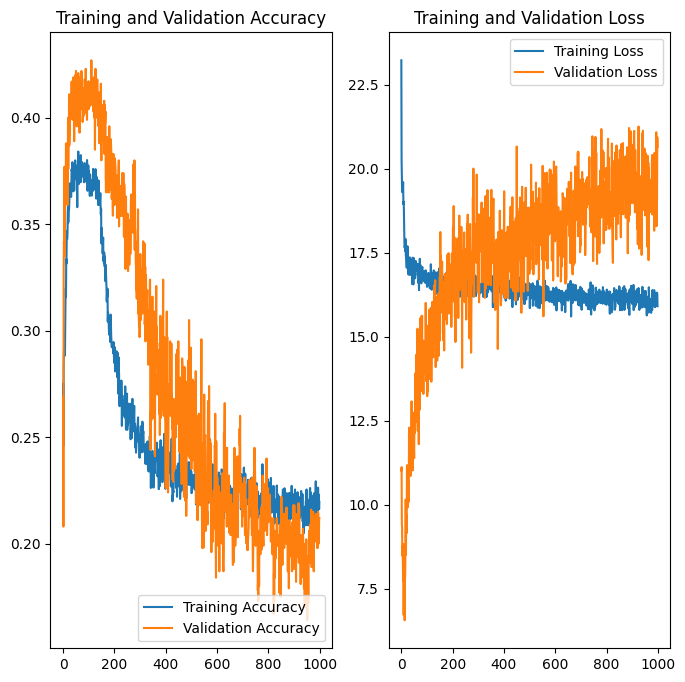

In [31]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [ ]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

In [ ]:
predictions = model.predict(campvectest)

In [ ]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [ ]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos de Accuracy y Loss

In [32]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 100,200/historycampvec100funcioncosto.csv', index = False)

# Guardamos el modelo

In [33]:
path_to_save = '../../../Modelos con ruido/Modelos 100,200'

In [34]:
model.save(path_to_save + '/campovectorial100funcioncosto.h5')

# Importamos el modelo

In [1]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

In [2]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [ ]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [3]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_loss':custom_loss,'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/campovectorial100funcioncosto.h5', 
                                    custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [4]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[2, 7, 9, 3, 9, 4, 2]


In [5]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [6]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 73ms/step
[[5. 5. 7. 5. 7. 5. 7.]]


##  Encontramos puntos de equilibro datos reales

In [7]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.0208599368562767, 3.106937887108622)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

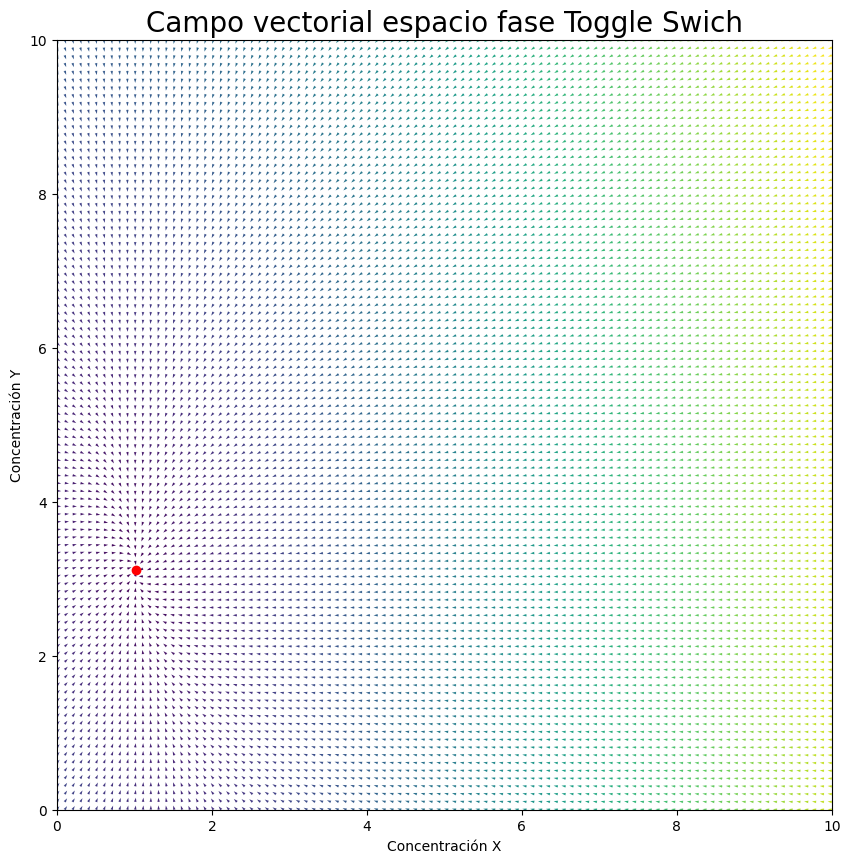

In [8]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [9]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.0083333582459488, 1.8854811346235518)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

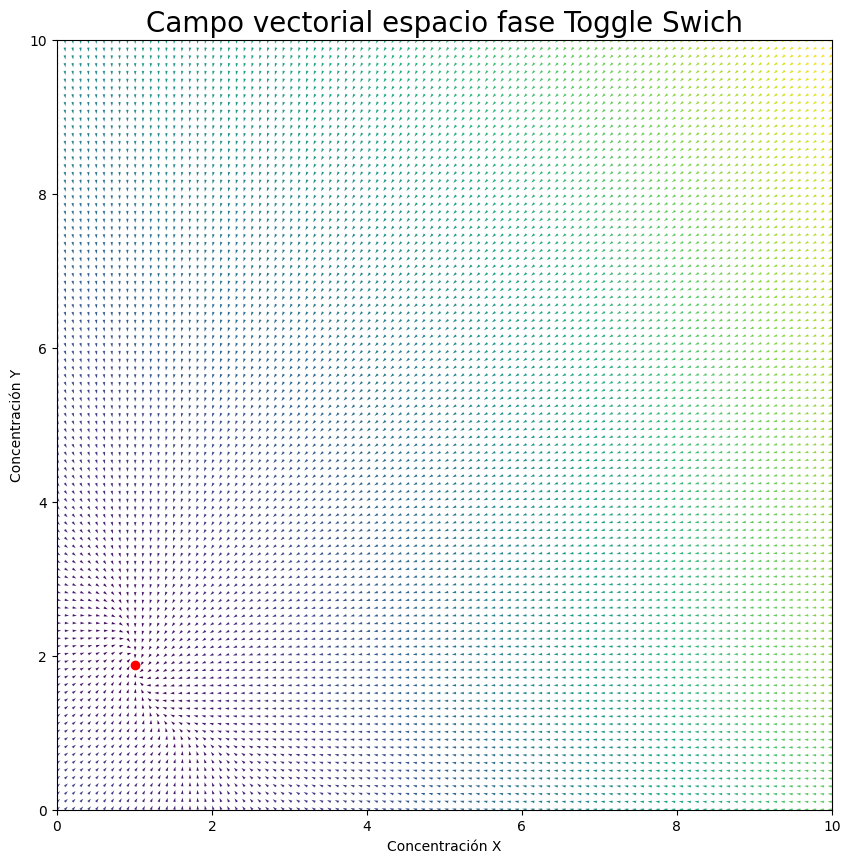

In [10]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

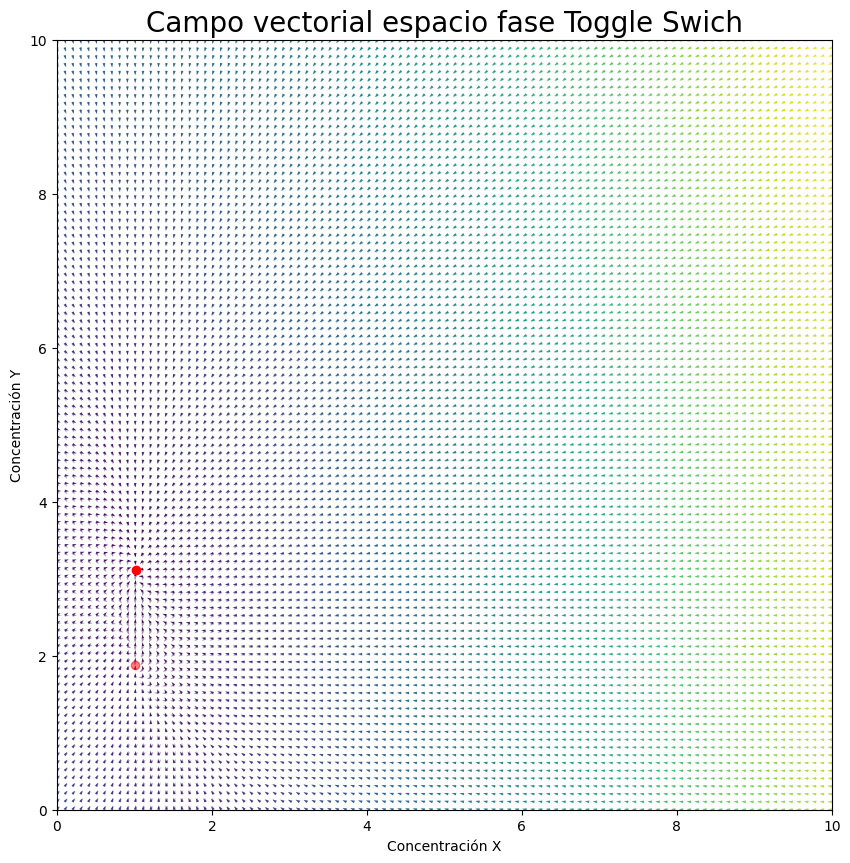

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

59.996683004322634


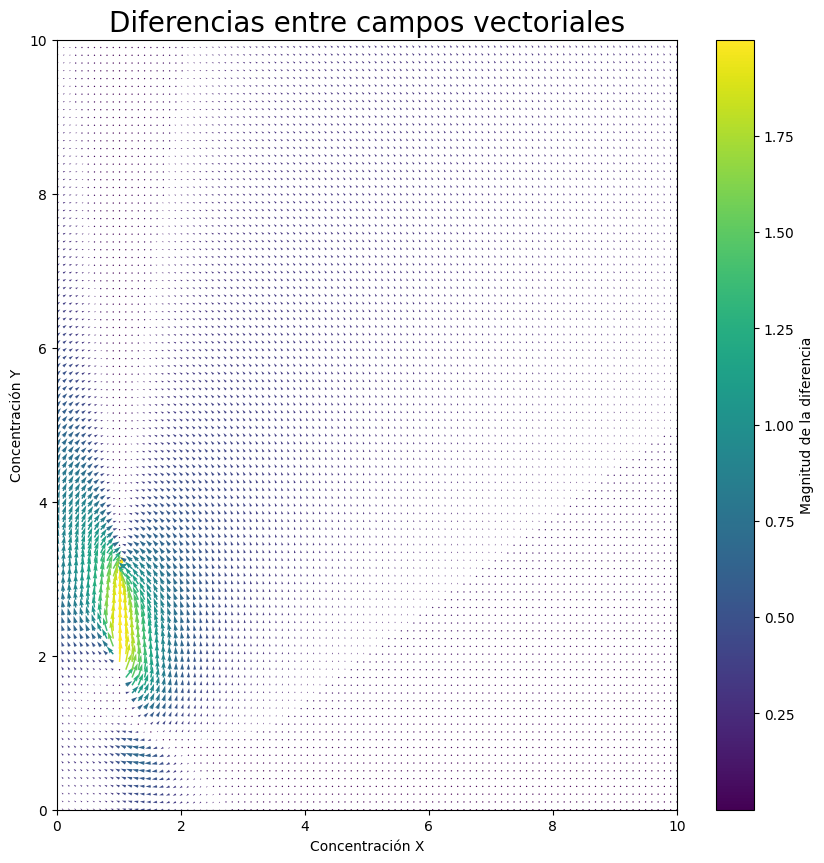

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [13]:
M_diff.mean()

0.24945830039979477

## Errores realativos

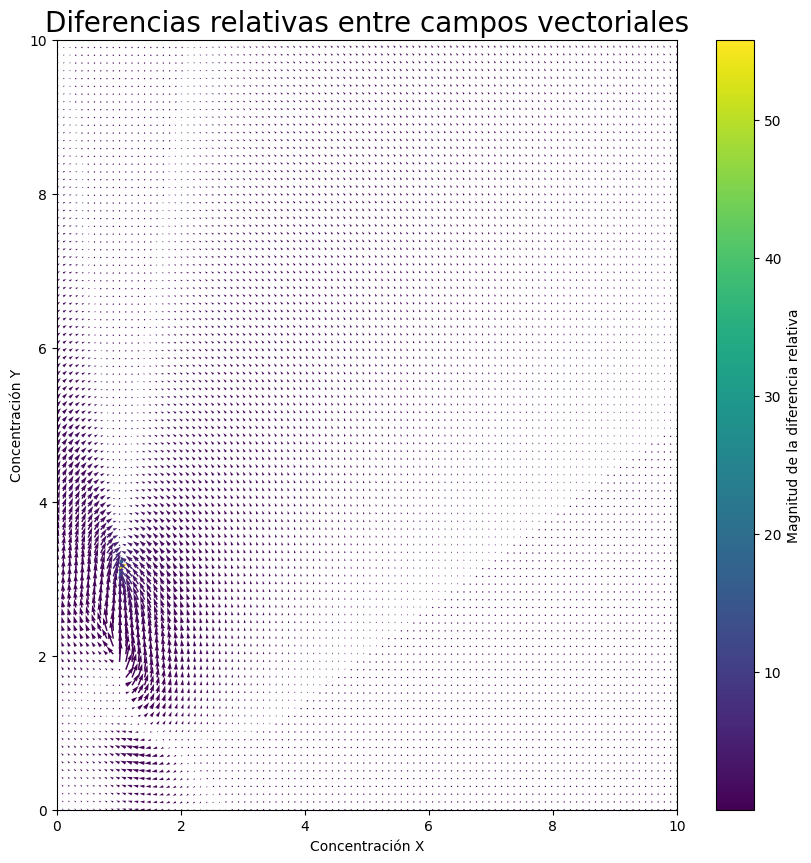

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [15]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 55.80445304842345
El valor de u1 en el error relativo máximo es: 0.09418831138172656
El valor de u1pred en el error relativo máximo es: -0.06901375707217738
El valor de v1 en el error relativo máximo es: -0.060427516414586435
El valor de v1pred en el error relativo máximo es: -6.244469841802719


In [16]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

55.804502915740755

In [27]:
M_diff_rel[max_coords]== 0
M_diff_rel.max()

15.968599891833499

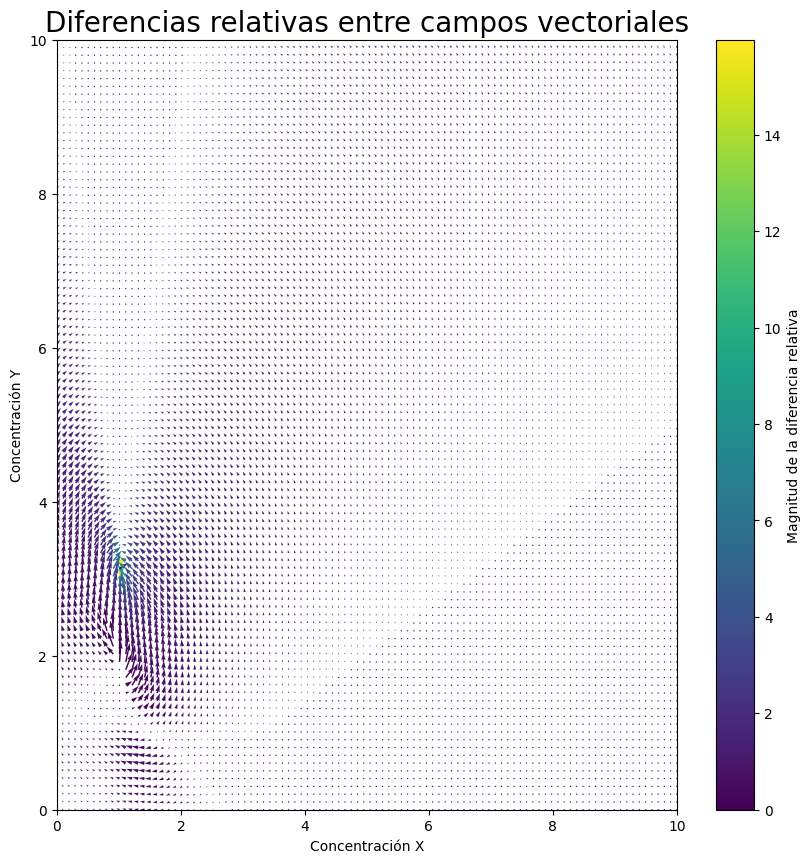

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()